# Predicting United States Real Estate Prices
By: Grace Li, Olivia Weisiger and Fionnuala Eastwood

### Outline
1. Dataset Preprocessing and Merging
2. Data Visualization
3. Classic Machine Learning Models
4. Deep Learning Models
5. Analysis of accuracy and results

### Context
The United States housing market is...

### Our Goal

This project will explore the current United States real-estate market, investigate what factors influence the price of property, and create multiple machine learning models that predict these housing costs throughout the country. More specifically, this will be accomplished through implementation of (add briefly about what models we end up using....) Being able to infer and understand the trends of real estate is extremely valuable economic knowledge that will provide important insights about our country. 

Furthermore, our project aims to deepen our understanding of how societal biases influence external structures such as the economy. By merging datasets, we will investigate which underlying factors such as (add briefly when choose other data) affect the prices of houses in order to draw deeper conclusions about intangible factors impacting our economic climate.

In [5]:
# pip install scikeras

### Import Packages and Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import plotly.express as px
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV # help find hyperparameters (e.g., num of hidden layers and neurons)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# For NN
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Input, Activation, Dropout
from tensorflow.keras.models import Model
from keras.activations import relu, sigmoid

# For determining how many layers/neurons
# pip install scikeras # needed for below
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

This data is from Kaggle's "USA Real Estate Dataset" found here: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [10]:
df = pd.read_csv('realtor-data.zip.csv')

### Initial Data Processing
Let's first break down what our dataset looks like...

In [13]:
df.shape

(2226382, 12)

We have a dataset with over 2 million rows and 12 columns. Since this is way too many samples to process in a reasonable computational time, we will take a random subset of 100,000 of these samples to perform analysis on.

In [15]:
random.seed(10)
df = df.sample(50000)
print(df.shape)

(50000, 12)


With our refined sample, let's get an idea of what our dataset looks like by outputting a few rows of the table.

In [17]:
df.head()

brokered_by    status     price  bed  bath  acre_lot     street  \
647142       96628.0  for_sale  185000.0  NaN   NaN     13.22  1894257.0   
171721       45850.0  for_sale   71250.0  NaN   NaN      2.57  1860014.0   
1496644      45751.0      sold   52000.0  3.0   2.0      0.38    14836.0   
415782      106265.0  for_sale  269900.0  3.0   2.0       NaN  1001056.0   
1585233      50928.0      sold  224995.0  3.0   3.0      0.07   633098.0   

                city         state  zip_code  house_size prev_sold_date  
647142      Pontotoc   Mississippi   38863.0         NaN            NaN  
171721       Bedford  Pennsylvania   15522.0         NaN            NaN  
1496644      Andover      New York   14806.0      1936.0     2022-04-07  
415782   Orange Park       Florida   32065.0      1168.0     2016-04-14  
1585233     Richmond      Virginia   23238.0      1340.0     2022-03-04

Notice that each sample in the dataset is a real estate listing in the United States (the listings are all from 2022-2024), and each sample has 12 features that provide numerical or categorical information about the listing.

Here is an overview of each feature's meaning and data type:

- brokered_by:

- status:

- price:

- bed:

- bath:

- etc fill in later (look on kaggle these descriptins are provided)

Now that we have an understanding of our data set, we will perform some processing on the data so that it is cleaner to use. Firstly, we will drop some unnecessary columns that do not contribute to our analysis goals. The brokered_by column which encodes the real-estate company in charge of the property is not necessary because we are interested in the qualities of the house itself. Additionally, the status column is not needed because we will use the price set for the house equivalently regardless if it is sold or for sale. Lastly, the previously sold date can be dropped since we are focused on the current selling price. We will trim our dataset from 12 columns to 9 with these modifications.

In [22]:
df = df.drop(['brokered_by', 'status', 'prev_sold_date'], axis=1)

This dataset contains listings from the United States and all it's territories. For our purposes, we only want to analyze data from the 50 states (and Washington, DC) so let's trim out samples taken from Puerto Rico and the Virgin Islands.

In [27]:
df = df[(df['state'] != "Puerto Rico") & (df['state'] != "Virgin Islands")]

Our next processing step is making sure we don't have any NaN's in our dataset, as empty data values might impact our analysis models.

In [31]:
#sum up all NaN values present in dataset (in any feature column)
print (df.isnull().sum().sum())

42568


We see that we have some data entries with no value, so let's remove all rows that contain any NaN values. We will also check the shape of our data frame after this removal to make sure we still have plenty of samples to work with.

In [34]:
#remove all rows missing data
df = df.dropna()

#verify we now have no NaN values, expect a value of zero
print (f'We now have: {df.isnull().sum().sum()} NaN entires')

#print new shape
print (f'Our new dataset shape is {df.shape}')


We now have: 0 NaN entires
Our new dataset shape is (30381, 9)


We successfully dropped all empty entries and still have a substantial size data frame to analyze.

### Dataset Merging

While the relationship between features such as number of rooms or number of acres on real-estate prices is quite intuitive, this project aims to delve beyond these variables and investigate more abstract influences. This will be done by merging our current dataframe with new datasets in order to add features including minimum wage of the state, median income by zip code, and even political affiliation, as we are curious if any of these variables will display a strong correlation with housing prices. One caution to note is that our original real estate data is from the past two years, so we will need to make sure the data we are merging with is taken from the same time period in order to obtain accurate conclusions.

The first dataset we will merge with is Kaggle's "US Household Income by Zip Code 2021-2011" found here: https://www.kaggle.com/datasets/claygendron/us-household-income-by-zip-code-2021-2011

In [39]:
df_income = pd.read_csv('us_income_zipcode.csv')
df_income.head()

ZIP       Geography Geographic Area Name  Households  \
0  601  860Z200US00601          ZCTA5 00601      5397.0   
1  602  860Z200US00602          ZCTA5 00602     12858.0   
2  603  860Z200US00603          ZCTA5 00603     19295.0   
3  606  860Z200US00606          ZCTA5 00606      1968.0   
4  610  860Z200US00610          ZCTA5 00610      8934.0   

   Households Margin of Error  Households Less Than $10,000  \
0                       264.0                          33.2   
1                       448.0                          27.1   
2                       555.0                          32.1   
3                       171.0                          28.4   
4                       372.0                          20.5   

   Households Less Than $10,000 Margin of Error  \
0                                           4.4   
1                                           2.9   
2                                           2.5   
3                                           5.5   
4                                           2.5   

   Households $10,000 to $14,999  \
0                           15.7   
1                           12.7   
2                           13.4   
3                           13.3   
4                           13.2   

   Households $10,000 to $14,999 Margin of Error  \
0                                            2.9   
1                                            2.1   
2                                            1.6   
3                                            4.4   
4                                            2.5   

   Households $15,000 to $24,999  ...  \
0                           23.9  ...   
1                           20.5  ...   
2                           17.2  ...   
3                           23.3  ...   
4                           23.3  ...   

   Nonfamily Households $150,000 to $199,999  \
0                                        0.0   
1                                        0.0   
2                                        0.6   
3                                        0.0   
4                                        0.0   

   Nonfamily Households $150,000 to $199,999 Margin of Error  \
0                                                2.8           
1                                                1.3           
2                                                0.6           
3                                                7.5           
4                                                1.8           

   Nonfamily Households $200,000 or More  \
0                                    0.0   
1                                    0.0   
2                                    0.2   
3                                    0.0   
4                                    0.0   

   Nonfamily Households $200,000 or More Margin of Error  \
0                                                2.8       
1                                                1.3       
2                                                0.4       
3                                                7.5       
4                                                1.8       

   Nonfamily Households Median Income (Dollars)  \
0                                        9386.0   
1                                       11242.0   
2                                       10639.0   
3                                       15849.0   
4                                       12832.0   

   Nonfamily Households Median Income (Dollars) Margin of Error  \
0                                             1472.0              
1                                             1993.0              
2                                              844.0              
3                                             3067.0              
4                                             2405.0              

   Nonfamily Households Mean Income (Dollars)  \
0                                     13044.0   
1                                     16419.0   
2                           

This dataset contains the results of the 2011 and 2021 national census, and we have chosen it in order to add a median income feature to our real estate pricing dataset. As explained above, we are only interested in the 2021 data since our pricing data comes from recent years, so we will trim down our dataset accordingly. Additionally, the dataset comes with dozens of feature columns, but for our purposes we only need to keep the zip code column (which we will use to merge our original dataset), and the median household income column. So let's process our dataset and display the cleaner result.

In [41]:
#select only samples from most recent census
df_income = df_income[df_income["Year"] == 2021.0]

#select only features we want
df_income = df_income[["ZIP", "Nonfamily Households Median Income (Dollars)"]]

df_income.head()

ZIP  Nonfamily Households Median Income (Dollars)
0  601                                        9386.0
1  602                                       11242.0
2  603                                       10639.0
3  606                                       15849.0
4  610                                       12832.0

Now we are ready to merge with our original dataset. Currently our zip code columns have different names so we will rename them identically, and they also have different types (integer vs float) so we will convert to a float variable to avoid type error interference.

In [43]:
df_income["ZIP"] = df_income["ZIP"].astype(float)

df_income = df_income.rename(columns={'ZIP': 'zip_code', "Nonfamily Households Median Income (Dollars)": 'income'})

We will use an inner merge (explain why...)
The census data was very thorough (we have very few NaN values), so we can just remove any empty data rows and our dataset remains practically the same. We verify this assumption by outputting our dataset shape after the merge.

In [45]:
df = pd.merge(df, df_income, on = ["zip_code"])

#remove all rows missing data
df = df.dropna()

print (df.shape)
df.head()

(30046, 10)


price  bed  bath  acre_lot     street         city       state  \
0   52000.0  3.0   2.0      0.38    14836.0      Andover    New York   
1  224995.0  3.0   3.0      0.07   633098.0     Richmond    Virginia   
2  675000.0  3.0   3.0      0.21  1729735.0    Elk Grove  California   
3  559900.0  5.0   3.0      0.17  1077672.0       Edmond    Oklahoma   
4  365000.0  3.0   2.0      0.15   730497.0  San Antonio       Texas   

   zip_code  house_size   income  
0   14806.0      1936.0  37083.0  
1   23238.0      1340.0  51037.0  
2   95624.0      2283.0  57994.0  
3   73034.0      2441.0  46828.0  
4   78261.0      1888.0  58981.0

This feature looks good, let's move on to some more merges.

Next, we want to add to our dataset statistics on political affiliation by state and minimum wage by state, which should be slightly simpler than merging by zipcode. 

First we will use is Kaggle's "2020 US Presidential Election Results by State" linked here: https://www.kaggle.com/datasets/callummacpherson14/2020-us-presidential-election-results-by-state. This data was taken appropriately recently to match our real-estate data, and it contains voting percentage and win vs loss data on Biden and Trump from the 2020 election.


In [47]:
df_election = pd.read_csv('voting.csv.xls')
df_election.head()

state state_abr  trump_pct  biden_pct  trump_vote  biden_vote  \
0      Alaska        AK       53.1       43.0      189543      153502   
1      Hawaii        HI       34.3       63.7      196864      366130   
2  Washington        WA       39.0       58.4     1584651     2369612   
3      Oregon        OR       40.7       56.9      958448     1340383   
4  California        CA       34.3       63.5     5982194    11082293   

   trump_win  biden_win  
0          1          0  
1          0          1  
2          0          1  
3          0          1  
4          0          1

Notice this is quite a clean dataset already, all we need to do is select the columns we are interested in and perform another inner merge along the column column of state. Here, we will choose to keep the state column which is needed for the merge, as well as the Trump pct, Biden pct columns since these provide more detailed information then the binary win vs loss columns. Let's do so and check our new dataset.

In [49]:
#select only features we want
df_election = df_election[["state", "biden_pct", "trump_pct"]]

#merge dataframe along the column of state
df = pd.merge(df, df_election, on = ["state"])

#verify there were no null data values added
print (f'We still have: {df.isnull().sum().sum()} NaN entires')

#output model summary
print (df.shape)
df.head()

We still have: 0 NaN entires
(30046, 12)


price  bed  bath  acre_lot     street         city       state  \
0   52000.0  3.0   2.0      0.38    14836.0      Andover    New York   
1  224995.0  3.0   3.0      0.07   633098.0     Richmond    Virginia   
2  675000.0  3.0   3.0      0.21  1729735.0    Elk Grove  California   
3  559900.0  5.0   3.0      0.17  1077672.0       Edmond    Oklahoma   
4  365000.0  3.0   2.0      0.15   730497.0  San Antonio       Texas   

   zip_code  house_size   income  biden_pct  trump_pct  
0   14806.0      1936.0  37083.0       57.1       41.5  
1   23238.0      1340.0  51037.0       54.4       44.2  
2   95624.0      2283.0  57994.0       63.5       34.3  
3   73034.0      2441.0  46828.0       32.3       65.4  
4   78261.0      1888.0  58981.0       46.5       52.1

Notice we still have no NaN entries, so our merging didn't add any problematic data and appears to be successfully added. 

Finally, we will perform this process one more time in order to add data on what each state's minimum wage is. This time we will use Kaggle's "Living Wage - State Capitals" found at https://www.kaggle.com/datasets/brandonconrady/living-wage-state-capitals. We again verified this was taken from the past two years for consistency.

In [51]:
df_minwage = pd.read_csv('LivingWageStateCapitals.csv.xls')
df_minwage.head()

state_territory         city  minimum_wage  \
0  District of Columbia   Washington         13.25   
1               Alabama   Montgomery          7.25   
2                Alaska       Juneau         10.19   
3               Arizona      Phoenix         12.00   
4              Arkansas  Little Rock         10.00   

   one_adult_no_kids_living_wage  one_adult_one_kid_living_wage  \
0                          19.97                          38.95   
1                          13.56                          27.35   
2                          15.48                          29.99   
3                          15.41                          29.44   
4                          13.97                          28.81   

   one_adult_two_kids_living_wage  one_adult_three_kids_living_wage  \
0                           48.99                             63.96   
1                           33.42                             42.17   
2                           36.00                             47.42   
3                           35.40                             46.01   
4                           35.49                             45.33   

   two_adults_one_working_no_kids_living_wage  \
0                                       29.61   
1                                       22.59   
2                                       24.48   
3                                       24.85   
4                                       23.21   

   two_adults_one_working_one_kid_living_wage  \
0                                       34.55   
1                                       26.66   
2                                       29.46   
3                                       29.25   
4                                       27.66   

   two_adults_one_working_two_kids_living_wage  ...  \
0                                        38.32  ...   
1                                        30.27  ...   
2                                        33.01  ...   
3                                        32.98  ...   
4                                        31.36  ...   

   one_adult_two_kids_poverty_wage  one_adult_three_kids_poverty_wage  \
0                            10.44                              12.60   
1                            10.44                              12.60   
2                            13.05                              15.75   
3                            10.44                              12.60   
4                            10.44                              12.60   

   two_adults_one_working_no_kids_poverty_wage  \
0                                         8.29   
1                                         8.29   
2                                        10.36   
3                                         8.29   
4                                         8.29   

   two_adults_one_working_one_kid_poverty_wage  \
0                                        10.44   
1                                        10.44   
2                                        13.05   
3                                        10.44   
4                                        10.44   

   two_adults_one_working_two_kids_poverty_wage  \
0                                         12.60   
1                                         12.60   
2                                         15.75   
3                                         12.60   
4                                         12.60   

   two_adults_one_working_three_kids_poverty_wage  \
0                                           14.75   
1                                           14.75   
2                                           18.44   
3                                           14.75   
4                                           14.75   

   two_adults_both_working_no_kids_poverty_wage  \
0                                          4.14   
1                                          4.14   
2                                          5.18   
3                                          4.14   
4         

Again, we want to select the columns we need which in this case is the state column to merge along and the minimum_wage column which has the minimum wage data we desire (in dollars). Here, we will also rename the "state_territory" column to have the same title "state" as our original dataframe to streamline the merging process. Then after we complete the inner merge we will verify our final dataset.

In [53]:
#select only features we want
df_minwage = df_minwage[["state_territory", "minimum_wage"]]

#rename state_territory column
df_minwage = df_minwage.rename(columns={'state_territory': 'state'})

#merge dataframe along the column of state
df = pd.merge(df, df_minwage, on = ["state"])

#verify there were no null data values added
print (f'We still have: {df.isnull().sum().sum()} NaN entires')

#output model summary
print (df.shape)
df.head()

We still have: 0 NaN entires
(30046, 13)


price  bed  bath  acre_lot     street         city       state  \
0   52000.0  3.0   2.0      0.38    14836.0      Andover    New York   
1  224995.0  3.0   3.0      0.07   633098.0     Richmond    Virginia   
2  675000.0  3.0   3.0      0.21  1729735.0    Elk Grove  California   
3  559900.0  5.0   3.0      0.17  1077672.0       Edmond    Oklahoma   
4  365000.0  3.0   2.0      0.15   730497.0  San Antonio       Texas   

   zip_code  house_size   income  biden_pct  trump_pct  minimum_wage  
0   14806.0      1936.0  37083.0       57.1       41.5         11.80  
1   23238.0      1340.0  51037.0       54.4       44.2          7.25  
2   95624.0      2283.0  57994.0       63.5       34.3         12.00  
3   73034.0      2441.0  46828.0       32.3       65.4          7.25  
4   78261.0      1888.0  58981.0       46.5       52.1          7.25

### Data Visualization

Our data visualization is necessary to serve two main purposes: the first being to come to conclusions about what factors (especially non-obvious ones like political affiliation for example) have a significant effect on housing prices. Recall that one of our main goals of this project was to investigate the role of these subtle biases on the housing market, and our visualization should allow us to conclude whether or not these patterns exist. The second purpose of visualization is to observe the impacts of individual features on our target column in order to inform our future models on how to prepare the dataset for machine learning algorithms.

First, let's get a general idea of what our dataset contains starting with our most important variable: price. I will display distribution plots of where our prices fall using a histogram, boxplot and violinplot. Notice that to aid the aesthetic of the visual (to prevent the x axis being too stretched out by outliers making the main shape more compressed) I eliminated the top and bottom 3% of prices.

/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


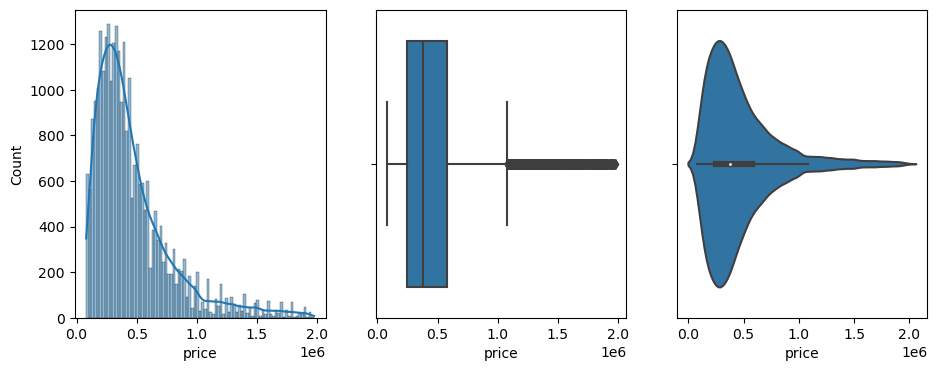

In [55]:
fig, axes = plt.subplots(1,3, figsize=(11, 4))

# Calculate the 3rd and 97th percentiles
lower_bound = df['price'].quantile(0.03)
upper_bound = df['price'].quantile(0.97)

# Filter the DataFrame to exclude the top and bottom 3% of prices
df_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Create a boxplot using Seaborn
sns.histplot(x='price', data=df_outliers, ax=axes[0], kde = True)

# Create a barplot using Seaborn
sns.boxplot(x='price', data=df_outliers, ax=axes[1])

# Create a violin plot using Seaborn
sns.violinplot(x='price', data=df_outliers, ax=axes[2])

plt.show()

We observe that our price data has a large clustering around median of aproximately 0.4 million, along with a skew right. Most of our data is clustered around the quarter million to half million range, but there are some very expensive samples that create the tail dragging in the high-priced direction. This makes logical sense given what we know about the housing market, as most homes are moderate sized and extremely expensive properties become more and more rare. We will be interested in exploring what features are present in these high-priced data points, as these will likely be our indicators of what determines an expensive property.

Now let's take a look at the distribution of our variables of house size, bed, and bath. Again we will ignore some outliers in order to highlight the shape of our distribution (if we extended the x axis farther to the right we would continue to see a practically flat zeroed out line)

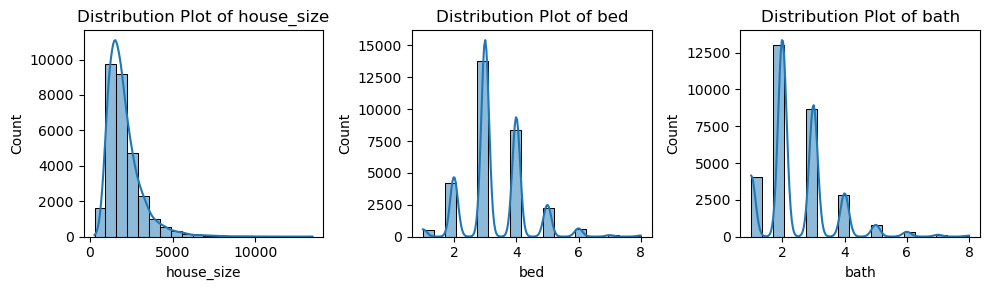

In [57]:
# prevent warnings from appearing
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

num_cols = ['house_size','bed', 'bath']

df_outliers = df.query('bed<=8 and bath <= 8 and house_size<= 15000')

# set up the plot
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# loop through the numeric columns and plot the distributions
for i, col in enumerate(num_cols):
    
    sns.histplot(df_outliers[col], ax=axes[i], kde=True, bins = 20)

    axes[i].set_title(f"Distribution Plot of {col}", wrap=True)
    axes[i].set_xlabel(col)
    
fig.tight_layout()

plt.show()

Similarly to price, these variables appear about as we would logically expect which indicates that our dataset did a good job sampling the real-world housing market. They each are unimodal with a slight skew to the right, which seems to mimick the price graph. Since the distributions appear similar, this may be a hint that these three variables have a strong correlation with price (or there is some underlying variable associated with both of them), which we will investigate farther later.

Next, let's look at the categorical variable of state, and verify how many data points of property we have per state. This time I perferred the formating of plotly to create a readable barplot.

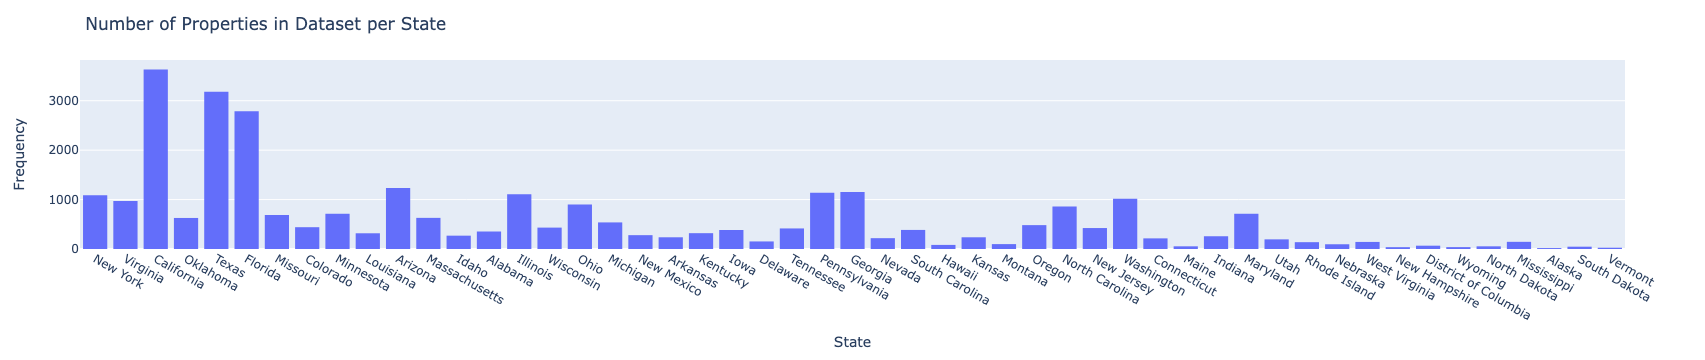

In [59]:
# Create a histogram using Plotly
fig = px.histogram(x=df["state"])

# Update layout
fig.update_layout(
    title="Number of Properties in Dataset per State",
    xaxis_title="State",
    yaxis_title="Frequency",
    showlegend=False
)

# Show the plot
fig.show()

We see that we have the most data samples coming from our large and populous states such as Florida, California, and Texas, while fewer samplings coming from smaller or more rural states. This also verifies that there are some samplings present from all 50 states. Based on this, our dataset seems to provide a pretty nice picture of the US housing market as a whole.

Now let's begin to investigate the impact of certain features on price, starting with a correlation map. This will use numerical data, so let's manually include some numerical features we are interested in, along with the price and above average price target columns.

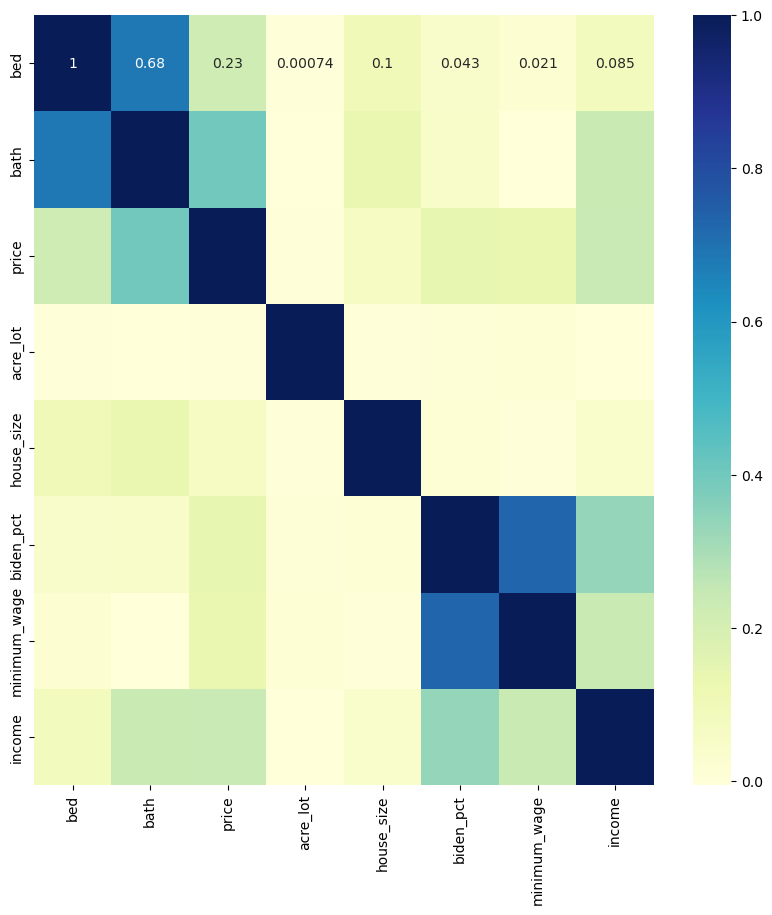

In [61]:
#take columns of numerical data we are interested in
df_corr = df[['bed', 'bath', 'price','acre_lot', 'house_size', 'biden_pct', 'minimum_wage', 'income']]

#correlation map
corr_data = df_corr.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_data, cmap="YlGnBu", annot = True)

plt.show()

We conclude that ...

Now let's analyze one of our major categorical features: state. The natural way to create a state vs price visual is to display on a map! We will create a choropleth map of the united states, where each state contains its mean housing price. This is done by using the groupby function as well as the plotly packages to visualize.

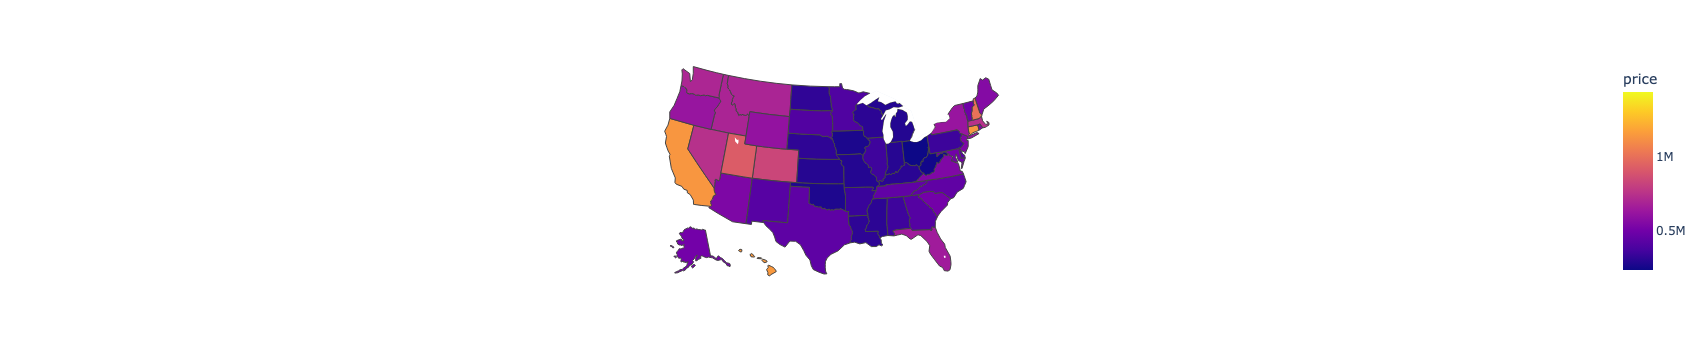

In [70]:
uniquestate_df = df[['state', 'price']]

uniquestate_df = uniquestate_df.groupby('state', as_index=False).mean()

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Map the state names to abbreviations
uniquestate_df['state_abbrev'] = uniquestate_df['state'].map(state_abbrev)

fig = px.choropleth(uniquestate_df, locations="state_abbrev",
                    locationmode="USA-states",
                    color="price",
                    scope = "usa",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

Our state map leads to some very interesting conclusions. Somewhat expectedly, California appears to be one of the most expensive states along with Hawaii, and the midwestern region states appear to be the chepest. We were somehwat surprised that New York was not more expensive, but given that our data focuses on housing listings not apartments, and uses price as a whole not price per square foot it makes sense that urban areas like New York City hold less gravity than one would think. These intricacies to our dataset are important to note, and will be very relevant moving forward.

Now along the same lines of state, let's move on to some of our more fun analysis. We want to conclude whether political affiliation and state minimum wage (2 of our merged datasets) appear to have any correlation with housing price. To do this let's again group by state to find the mean price for each state, and create plots that display a regression line and confidence interval for the relationship between variables.

Text(0, 0.5, 'Mean State Housing Price')

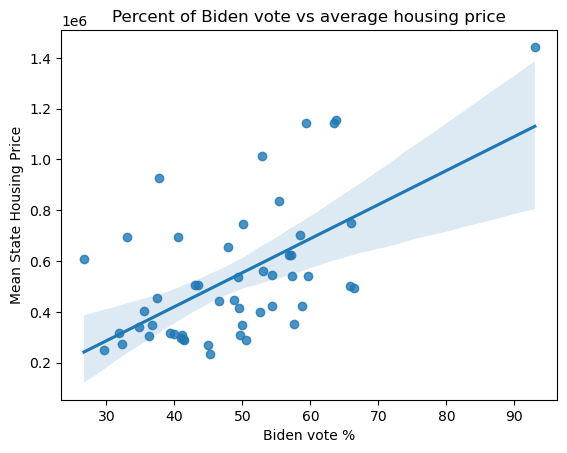

In [73]:
uniquestate_df = df[['state', 'biden_pct', "price", 'minimum_wage']]

uniquestate_df = uniquestate_df.groupby('state', as_index=False).mean()

fig = sns.regplot(data = uniquestate_df, x = 'biden_pct', y= 'price')

# Add title and labels
plt.title('Percent of Biden vote vs average housing price')
plt.xlabel('Biden vote %')
plt.ylabel('Mean State Housing Price')

Political affiliation conclusion: 

Text(0, 0.5, 'Mean State Housing Price')

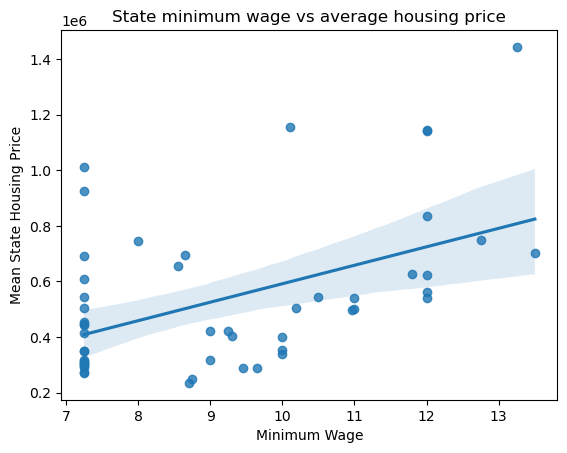

In [76]:
fig = sns.regplot(data = uniquestate_df, x = 'minimum_wage', y= 'price')

# Add title and labels
plt.title('State minimum wage vs average housing price')
plt.xlabel('Minimum Wage')
plt.ylabel('Mean State Housing Price')

Minimum Wage Conclusion

Recalling our correlation graph output, now let's work through exploring some individual numerical features and their relationship with house price. Specifically, we will investigate the trend lines of bed, bath, and house size with price. Notice that we turned off the scattering in order to not clutter the plot, and instead just use the regression line and confidence interval.

(0.0, 3500000.0)

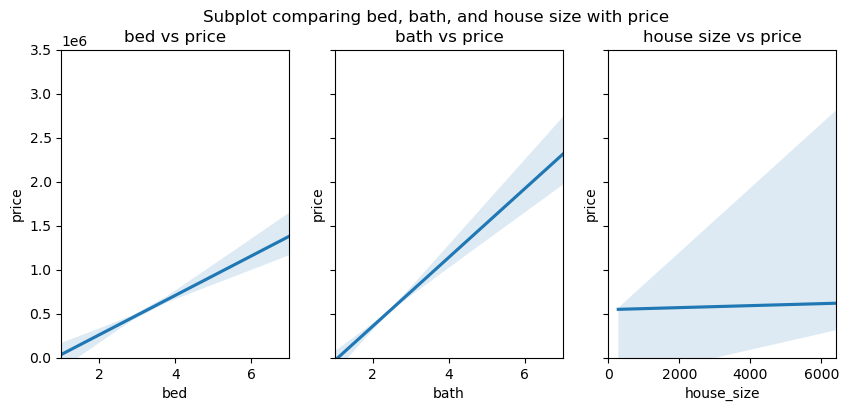

In [78]:
# subplot

fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,4))
fig.suptitle('Subplot comparing bed, bath, and house size with price')

sns.regplot(data = df, x="bed", y="price", ax=ax[0], scatter = False)
ax[0].set_title('bed vs price')
ax[0].set_xlim(1, df['bed'].quantile(0.99))
ax[0].set_ylim(0, df['price'].quantile(0.99))

sns.regplot(data = df, x="bath", y="price", ax=ax[1], scatter = False)
ax[1].set_title('bath vs price')
ax[1].set_xlim(1, df['bath'].quantile(0.99))
ax[1].set_ylim(0, df['price'].quantile(0.99))

sns.regplot(data = df, x="house_size", y="price", ax=ax[2], scatter = False)
ax[2].set_title('house size vs price')
ax[2].set_xlim(0, df['house_size'].quantile(0.99))
ax[2].set_ylim(0, df['price'].quantile(0.99))

This result is about as expected from the correlation heatmap. We see that bath appears to be the most influential on price, while house size is surprisingly unimportant. This helps us conclude that bath, followed by bed variables should be more heavily useful features for our predictive machine learning models. Let's look into these two important features in a little more depth by creating a barplot that displays the average price per bedroom/bathroom quantity.

/var/folders/s3/4mwfywvj5ss6j0jj7sbftl180000gn/T/ipykernel_3273/1156830630.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/s3/4mwfywvj5ss6j0jj7sbftl180000gn/T/ipykernel_3273/1156830630.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



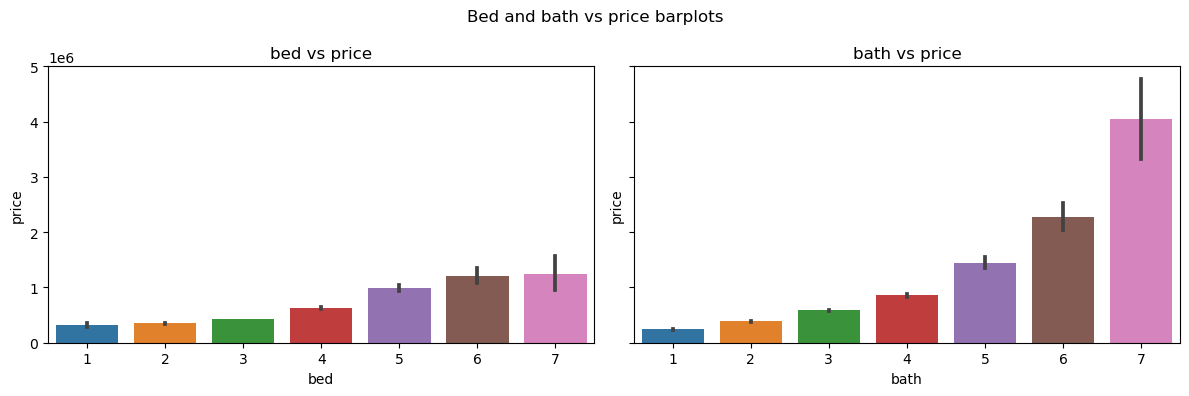

In [81]:
df_barplot = df[(df['bed'] <= df['bed'].quantile(0.99)) & (df['bath'] <= df['bath'].quantile(0.99))]

df_barplot['bed'] = df_barplot['bed'].astype(int)
df_barplot['bath'] = df_barplot['bath'].astype(int)


fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
fig.suptitle('Bed and bath vs price barplots')

sns.barplot(data = df_barplot, x="bed", y="price", ax=ax[0])
ax[0].set_title('bed vs price')

sns.barplot(data = df_barplot, x="bath", y="price", ax=ax[1])
ax[1].set_title('bath vs price')

fig.tight_layout()


Our last highly important numerical data feature to break down is the median income column. We noticed in our correlation map that it appeared one of the more influential variables, so let's get a better understanding through some visualization. First let's create a more fun, interactive map with plotly that takes a small subset of our datapoints and displays the price of the smaple vs the median income (recall measured by zipcode). We can click around by hovering over the samples to get a feel for some data points and possible relationships between the variables.

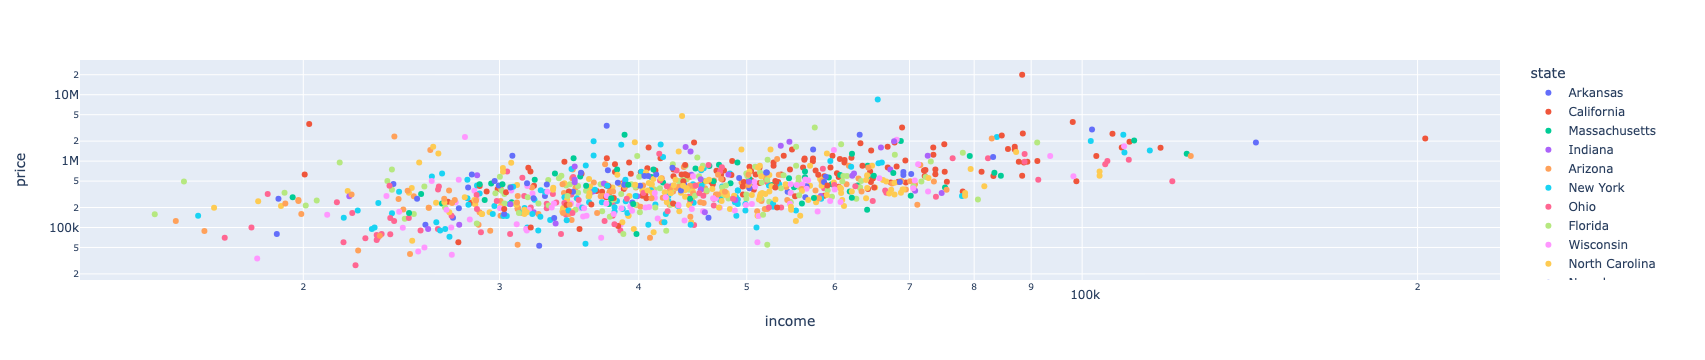

In [83]:
df2 = df.sample(1000)
fig = px.scatter(df2, x="income", y="price", color="state",
           hover_name="state", log_x=True, log_y=True, size_max=60)
fig.show()

Notice there appears to be an upward trend in increasing income and increasing price, which does make logical makes. Let's see this formally using our full sample (the mini sampling was just so that we could have a reasonable ammount of scatterings that didn't clutter it). Again this time we turn off scatter and just plot the regression line.

(0.0, 5000000.0)

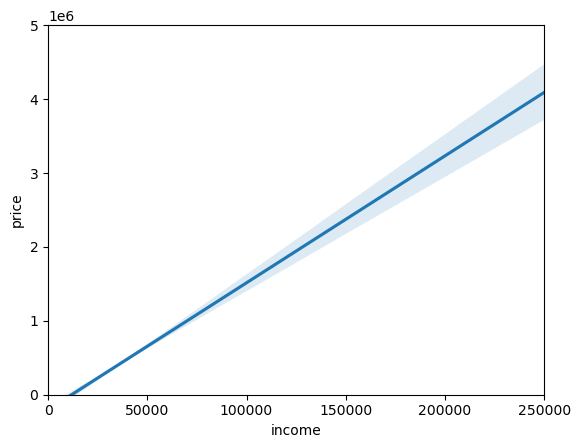

In [85]:
uniquezip_df = df[['zip_code', 'income', "price"]]

uniquezip_df = uniquezip_df.groupby('zip_code', as_index=False).mean()

fig = sns.regplot(data = uniquezip_df, x = 'income', y= 'price', scatter = False)
fig.set_xlim(0, 250000)
fig.set_ylim(0, 5000000)

Our resultant regression line first of all has a noticeably positive slope, and second of all has a relatively tight confidence interval. This indicates that our variable of median income by zip code appears to be a nice predictor of price, and will likely become very important in informing our future machine learning models.

### Data Prep for Machine Learning Models

***Categorizing Price***

When beginning to develop a machine learning model, our first obstacle we encounter is what exactly we want to predict. We noticed that predicting the price to an exact number (as the current column does) is quite specific, so instead  we will want to predict whether any piece of real-estate is more generally expensive or cheap in a categorical fashion. The next question that follows is ***how we will quantify this "expensive" vs "cheap"***. 

Our natural thought was just categorizing the samples based on if they were on the higher half of all in our dataset vs the lowest. However, upon further analysis we realize that the state the property is in has an overwhelmingly powerful influence on this categorization. For example, we would see that practically all samples from California would fall in the upper portion of data, while a huge majority of samples from rural states will be in the lower. This would leave our model with very little to do, and provides less informative/impressive conclusions. So to work around this and create a more challenging problem, we have decided to create a categorical column that contains a 1 if the property price is above the median housing price **of the state it is in**, and a 0 if the property is below this median average of its state. This takes out the state bias and may lead to more informative conclusions about other features that are no longer overshadowed.

To do this, we first merge data with the median housing prices by state. This data was taken from the following link: https://www.bankrate.com/real-estate/median-home-price/#how-much, and is up to date as of November 2023 (which is the same time period our real-estate data was taken from).

In [93]:
#upload data
df_med = pd.read_csv('median_prices.csv')
df_med.head()

#select state and median price columns we want
df_med = df_med[["state", "med_price"]]

#merge along state column
df = pd.merge(df, df_med, on = ["state"])
df.head()

price  bed  bath  acre_lot     street         city       state  \
0   52000.0  3.0   2.0      0.38    14836.0      Andover    New York   
1  224995.0  3.0   3.0      0.07   633098.0     Richmond    Virginia   
2  675000.0  3.0   3.0      0.21  1729735.0    Elk Grove  California   
3  559900.0  5.0   3.0      0.17  1077672.0       Edmond    Oklahoma   
4  365000.0  3.0   2.0      0.15   730497.0  San Antonio       Texas   

   zip_code  house_size   income  biden_pct  trump_pct  minimum_wage med_price  
0   14806.0      1936.0  37083.0       57.1       41.5         11.80  $649,000  
1   23238.0      1340.0  51037.0       54.4       44.2          7.25  $415,600  
2   95624.0      2283.0  57994.0       63.5       34.3         12.00  $793,600  
3   73034.0      2441.0  46828.0       32.3       65.4          7.25  $233,900  
4   78261.0      1888.0  58981.0       46.5       52.1          7.25  $336,400

Notice one more problem exists: we have a price listed in string form with dollar sign and commas. Instead we want it to be numerical in order to compare it with our current price column.

In [96]:
# Remove dollar signs and commas, then convert to integers
df['med_price'] = df['med_price'].replace({'\$': '', ',': ''}, regex=True).astype(int)

Lastly, we want to create a new column which we will call above_average. This column will contain a 1 if the price of that sample is above the median price in the state, and a 0 if it is below. We will also remove the median price column afterwards because it served its purpose, as well as the price column because the categorical variable will replace it. Otherwise, in our model we would be using price to inform "above average price" which does seem like cheating.

In [99]:
df['above_average'] = df.apply(lambda row: 1 if row['price'] > row['med_price'] else 0, axis=1)
df = df.drop(columns = ['med_price', 'price'])
df.head()

bed  bath  acre_lot     street         city       state  zip_code  \
0  3.0   2.0      0.38    14836.0      Andover    New York   14806.0   
1  3.0   3.0      0.07   633098.0     Richmond    Virginia   23238.0   
2  3.0   3.0      0.21  1729735.0    Elk Grove  California   95624.0   
3  5.0   3.0      0.17  1077672.0       Edmond    Oklahoma   73034.0   
4  3.0   2.0      0.15   730497.0  San Antonio       Texas   78261.0   

   house_size   income  biden_pct  trump_pct  minimum_wage  above_average  
0      1936.0  37083.0       57.1       41.5         11.80              0  
1      1340.0  51037.0       54.4       44.2          7.25              0  
2      2283.0  57994.0       63.5       34.3         12.00              0  
3      2441.0  46828.0       32.3       65.4          7.25              1  
4      1888.0  58981.0       46.5       52.1          7.25              1

Let's also verify that we successfully only added either a 0 or 1 in every column, so we have 2 categories.

In [101]:
df[["above_average"]].agg("nunique")

above_average    2
dtype: int64

In [102]:
binary_split_percentage = np.unique(df[["above_average"]], return_counts=True)[1] / len(df[["above_average"]])
print("The percentage below median price per that state is", round(binary_split_percentage[0] * 100, 2),
      "% and the percentage above median price per that state is", round(binary_split_percentage[1] * 100, 2))

The percentage below median price per that state is 55.03 % and the percentage above median price per that state is 44.97


This looks good, now let's also verify that we have approximately an even split between samples that were given 0 and 1 values to make sure our categorization worked correctly. We will display this distribution as a barplot.

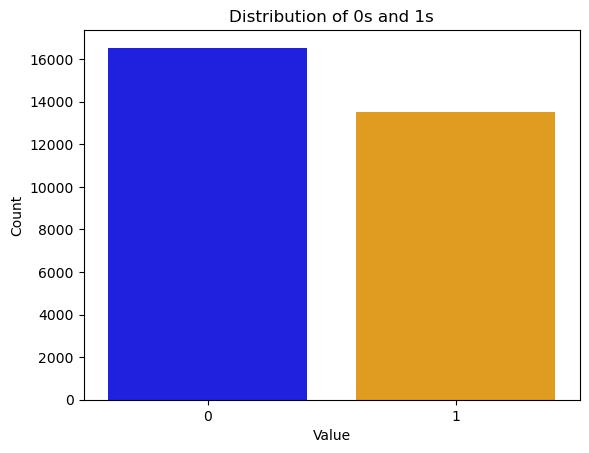

In [104]:
sns.countplot(data = df, x="above_average", palette=['blue', 'orange'])

# Add title and labels
plt.title('Distribution of 0s and 1s')
plt.xlabel('Value')
plt.ylabel('Count')

# Display the plot
plt.show()

This split seems very appropriate to use for our classification problem.

***Making all data numeric***

The next preparation challenge we encounter is that our code uses categorical, non-numerical columns such as "state" and "city", and these won't work with many dimension reduction techniques or machine learning models. So, we must assign our categorical names into binary/numeric data in order to proceed

To do this we first must determine which columns we need to change, meaning we need to check which columns are categorical and which are numerical.

In [108]:
# these two lists hold the columns that are numerical versus categorical
numeric = []
categoric = []

# iterate through the dataframe and sort the column into the numeric list if the type is int or float, otherwise sorting it into the categorical list.
for col in df.columns:
    if df[col].dtype == np.float64 or df[col].dtype == np.int64:
        numeric.append(col)
    else:
        categoric.append(col)

# print
print('Numeric columns:', numeric)
print('Categorical columns:', categoric)

Numeric columns: ['bed', 'bath', 'acre_lot', 'street', 'zip_code', 'house_size', 'income', 'biden_pct', 'trump_pct', 'minimum_wage', 'above_average']
Categorical columns: ['city', 'state']


After determining which columns are categorical, and therefore need to be changed to numeric values, our first attempt to manipulate these columns is to use hot encoding.

In [110]:
# create a copy of the data so that we dont affect the origional dataframe
data = df.copy()

# one hot encode categorical features that we discovered in the last cell
one_hot_encoded_data = pd.get_dummies(data, columns = ['city', 'state'])

# print our data to understand what we are working with
one_hot_encoded_data.head()


bed  bath  acre_lot     street  zip_code  house_size   income  biden_pct  \
0  3.0   2.0      0.38    14836.0   14806.0      1936.0  37083.0       57.1   
1  3.0   3.0      0.07   633098.0   23238.0      1340.0  51037.0       54.4   
2  3.0   3.0      0.21  1729735.0   95624.0      2283.0  57994.0       63.5   
3  5.0   3.0      0.17  1077672.0   73034.0      2441.0  46828.0       32.3   
4  3.0   2.0      0.15   730497.0   78261.0      1888.0  58981.0       46.5   

   trump_pct  minimum_wage  ...  state_South Dakota  state_Tennessee  \
0       41.5         11.80  ...               False            False   
1       44.2          7.25  ...               False            False   
2       34.3         12.00  ...               False            False   
3       65.4          7.25  ...               False            False   
4       52.1          7.25  ...               False            False   

   state_Texas  state_Utah  state_Vermont  state_Virginia  state_Washington  \
0        False       False          False           False             False   
1        False       False          False            True             False   
2        False       False          False           False             False   
3        False       False          False           False             False   
4         True       False          False           False             False   

   state_West Virginia  state_Wisconsin  state_Wyoming  
0                False            False          False  
1                False            False          False  
2                False            False          False  
3                False            False          False  
4                False            False          False  

[5 rows x 6145 columns]

Above, we can see that the hot encoding has taken the two categorical columns, seperated each of the different values into their own unique column, and assigned binary(true/false) to their association with the values of other features. Even though this has done what we were interested in it accomplishing - making the categorical columns numerical - we notice that there are way too many columns so the data is very complex and has a huge input shape of thousands of features. Since this will make training a deep learning model to be extremely computationally expensive, let's see if another method provides a cleaner result- we will try label encoding.

Label encoding further simplifies the number of columns for kernel pca, as the hot encoding creates too many columns to be used. In label encoding, each unique category value is assigned an integer - making our data numerical.

In [114]:
# create the label encoder
label_encoder = LabelEncoder()

# create the label encoded data
label_encoded_data = df.copy()
label_encoded_data['state'] = label_encoder.fit_transform(label_encoded_data['state'])
label_encoded_data['city'] = label_encoder.fit_transform(label_encoded_data['city'])

# create X and y data
X_le = label_encoded_data.drop(['above_average'], axis=1)
y_le = label_encoded_data['above_average']

# split into train and test sets
#set the random state to be the same for all train test splits so we know our results are from the same data.
train_Xle, test_Xle, train_yle, test_yle = train_test_split(X_le, y_le, test_size=0.33, random_state=42)

# scale the numeric features using standardization
scaler = StandardScaler()
train_Xle = scaler.fit_transform(train_Xle)
test_Xle = scaler.transform(test_Xle)

In [116]:
# Visualise the label encoded data
label_encoded_data

bed  bath  acre_lot     street  city  state  zip_code  house_size  \
0      3.0   2.0      0.38    14836.0   123     32   14806.0      1936.0   
1      3.0   3.0      0.07   633098.0  4581     46   23238.0      1340.0   
2      3.0   3.0      0.21  1729735.0  1595      4   95624.0      2283.0   
3      5.0   3.0      0.17  1077672.0  1553     36   73034.0      2441.0   
4      3.0   2.0      0.15   730497.0  4804     43   78261.0      1888.0   
...    ...   ...       ...        ...   ...    ...       ...         ...   
30041  4.0   3.0      0.08  1441337.0   946     13   60644.0      3304.0   
30042  4.0   4.0      0.18  1736469.0  3050     10   30052.0      2812.0   
30043  2.0   1.0      0.11   806765.0   367     47   98225.0      1025.0   
30044  3.0   3.0      0.02  1065407.0  2899     38   19446.0      1765.0   
30045  5.0   4.0      0.32  1751096.0  4010     42   37363.0      3225.0   

        income  biden_pct  trump_pct  minimum_wage  above_average  
0      37083.0       57.1       41.5         11.80              0  
1      51037.0       54.4       44.2          7.25              0  
2      57994.0       63.5       34.3         12.00              0  
3      46828.0       32.3       65.4          7.25              1  
4      58981.0       46.5       52.1          7.25              1  
...        ...        ...        ...           ...            ...  
30041  18808.0       57.6       40.5         10.00              1  
30042  47308.0       49.5       49.3          7.25              1  
30043  36563.0       58.4       39.0         13.50              0  
30044  53413.0       50.0       48.8          7.25              1  
30045  50848.0       37.4       60.7          7.25              1  

[30046 rows x 13 columns]

As shown above, the label encoded data is much more condensed than the hot encoded data, as each element in the categorical columns have been given a unique value. So we will use our label encoded data for our future models.

# Feature Selection

Before feature selection, we will build a random forest classifier using the default `n_estimators = 10` (number of decision trees in the forest). This will act as a baseline to help us understand the approximate accuracy that may be achieved. 

Accuracy is:  82.87 %


<Axes: >

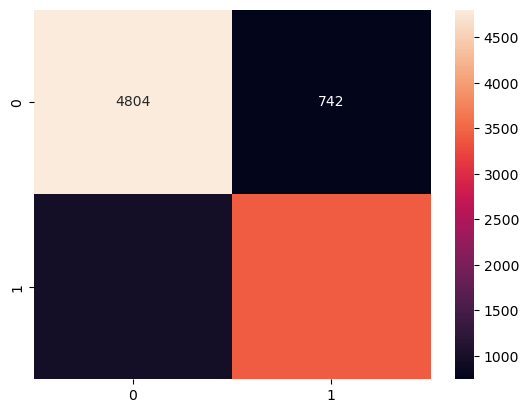

In [131]:
# Build a random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state = 43)      
clr_rf = clf_rf.fit(train_Xle, train_yle)

# calculating accuracy
ac = accuracy_score(test_yle, clf_rf.predict(test_Xle))
print('Accuracy is: ', round(ac*100, 2), "%")

# create the conf mat
cm = confusion_matrix(test_yle, clf_rf.predict(test_Xle))
sns.heatmap(cm, annot = True, fmt = "d")

From the confusion matrix, we can see that the RF classifier performs fairly well, yet it does make some erroors in classification. Next, we will try feature selection methods to see if we can find more accurate results.

### Recursive Feature Elimination (RFE) with Cross-Validation and Random Forest Classification

RFE is a feature elimination selection technique that searches for a subset of key features in a training dataset that are most relavent in predicting the target variable. 

In this case, we are using a random forest classifier with 5-fold cross validation. The data will be randomly split into 5 folds, and the random forest classifier will be trained on 4 folds while the other fold is left to test the model. This is repeated 5 times and then we are able to average the testing accuracy over the 5 folds. 

Optimal number of features : 12
Best features : Index(['bed', 'bath', 'acre_lot', 'street', 'city', 'state', 'zip_code',
       'house_size', 'income', 'biden_pct', 'trump_pct', 'minimum_wage'],
      dtype='object')


Text(0, 0.5, 'Mean Test Accuracy')

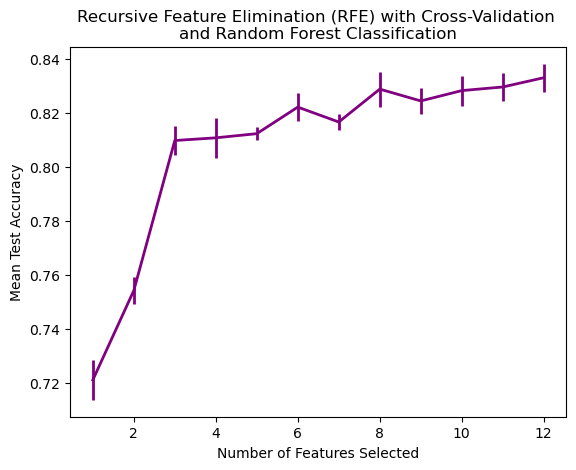

In [134]:
# creating RF classifier
clf_rf_3 = RandomForestClassifier() 
rfecv = RFECV(estimator = clf_rf_3, step = 1, cv = 5, scoring = 'accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(train_Xle, train_yle)

print('Optimal number of features :', rfecv.n_features_)

# using train_X since it is pandas df and we want .columns names
print('Best features :', X_le.columns[rfecv.support_])

# Plotting mean test accuracy calculated across cross validations with error bar
plt.errorbar(
    x = range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    y = rfecv.cv_results_["mean_test_score"],
    yerr = rfecv.cv_results_["std_test_score"],
    color = 'purple', linewidth = 2
)

# Add title and labels
plt.title('Recursive Feature Elimination (RFE) with Cross-Validation \nand Random Forest Classification')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Accuracy')

From the plot above, we can see that the optimal number of features is all 12 as the training accuracy continues to increase with the addition of each one. The error bars help us visualize the error or uncertainty in the average testing aaccuracy given the number of features selected.

### Tree-Based Feature Selection in Random Forest Classification

Next, we will try tree-based feature selection in RF classification to investigate if it yields similar results. The method will also allow us to understand how the features rank compared to eachother. 

Feature ranking:
1. feature 7 (0.263104)
2. feature 8 (0.152640)
3. feature 1 (0.108085)
4. feature 6 (0.096014)
5. feature 2 (0.081749)
6. feature 3 (0.071670)
7. feature 4 (0.071189)
8. feature 0 (0.048774)
9. feature 10 (0.029987)
10. feature 5 (0.029889)
11. feature 9 (0.029870)
12. feature 11 (0.017028)


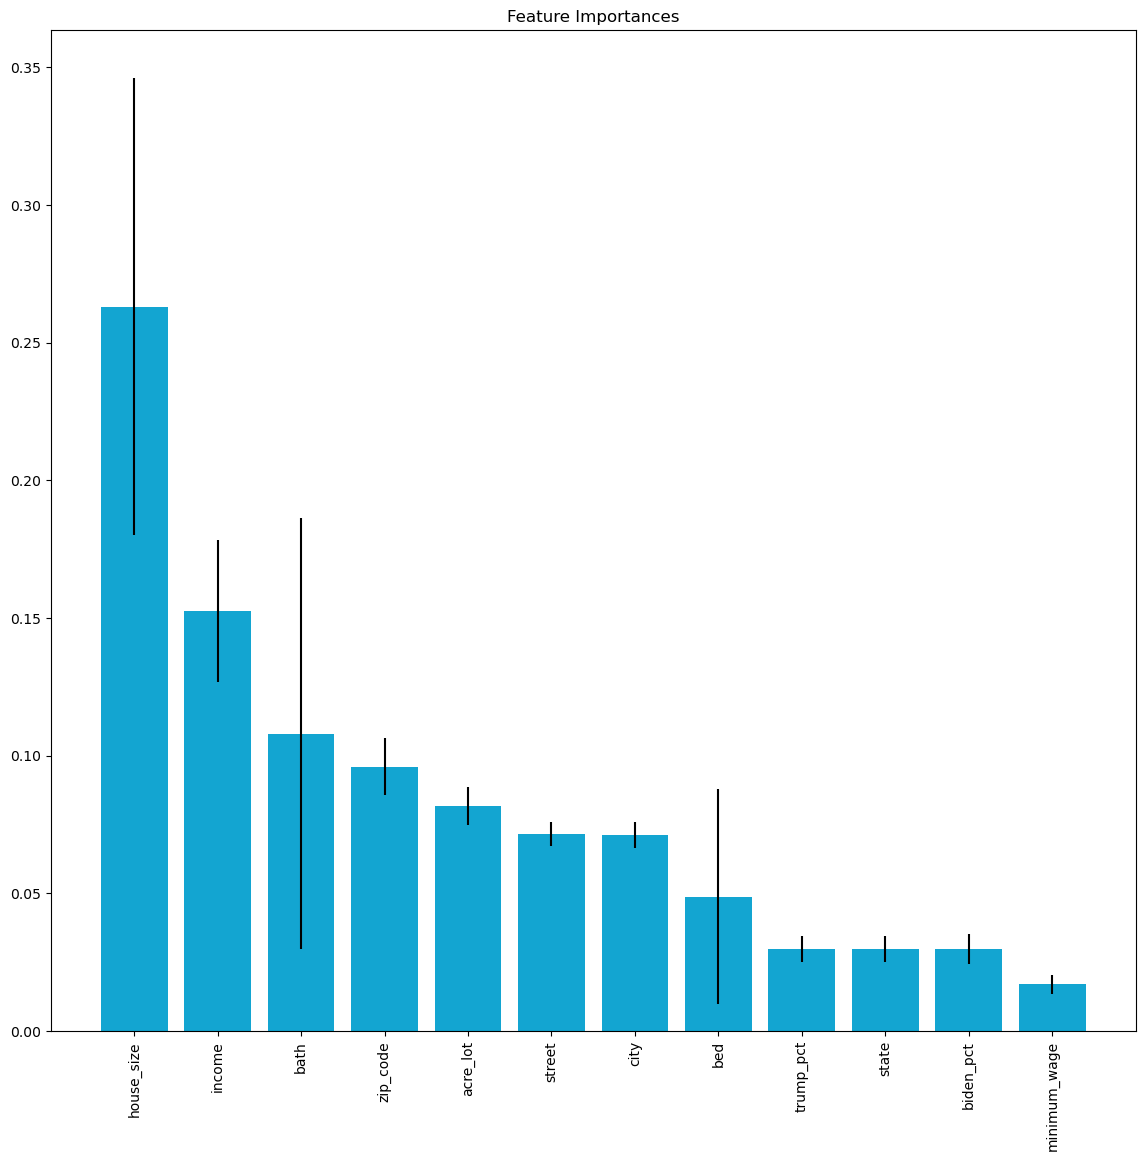

In [136]:
# creating the RF classifier
clf_rf_4 = RandomForestClassifier()      

# fitting it
clr_rf_4 = clf_rf_4.fit(train_Xle, train_yle)

# storing importances
importances = clr_rf_4.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis = 0)
indices = np.argsort(importances)[::-1]
 
# Print the feature ranking
print("Feature ranking:")
 
for f in range(train_Xle.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f],  importances[indices[f]]))

# Plot the feature importance list:
plt.figure(1, figsize = (14, 13))
plt.title("Feature Importances")
plt.bar(
    range(train_Xle.shape[1]), 
    importances[indices],
    color = "#13a5d1", yerr = std[indices], 
    align = "center"
)
plt.xticks(range(train_Xle.shape[1]), 
           X_le.columns[indices],
           rotation=90)
plt.xlim([-1, train_Xle.shape[1]])
plt.show()

The feature importance for each tree in the Random Forest, is a measure the improvement in impurity (Gini impurity or mean squared error) at each split point for a particular attribute. The average improvement over all trees for each attribute is calcuated. The higher the average improvement, the more important the feature is considered.

For reference:

In [138]:
for fet, i in enumerate(X_le.columns):
    print("feature", fet, "is", i)

feature 0 is bed
feature 1 is bath
feature 2 is acre_lot
feature 3 is street
feature 4 is city
feature 5 is state
feature 6 is zip_code
feature 7 is house_size
feature 8 is income
feature 9 is biden_pct
feature 10 is trump_pct
feature 11 is minimum_wage


From the feature importance plot, we can see that house size is the most important feature, followed by income, number of bathrooms, zip code, acres, street, city, and number of bedrooms. The last four features in the data (biden and trump vote percentage, state, and minimum wage) are the least important in making accurate predictions. However, we will maintain these features in the model because of the reccommendation from the RFE with CV and RF classification algorithm above.

## Dimension Reduction

###  PCA

Dimension reduction is a commonly employed strategy before training machine learning models, so let's explore whether or not we should use it here.

In [141]:
# Call PCA command on training data
pca = PCA(n_components = 12) # creating an algorithm to conduct PCA with 8 principle components

# fit to the training data
train_Xle_pca = pca.fit_transform(train_Xle)

In [142]:
expl_var_ratio = pca.explained_variance_ratio_
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

print(expl_var_ratio)
print(cum_ratio)

[2.50430552e-01 1.50264847e-01 8.87165993e-02 8.39108737e-02
 8.28648599e-02 8.13229233e-02 7.86820845e-02 7.69892992e-02
 6.22078289e-02 2.34801948e-02 2.10489653e-02 8.09719383e-05]
[0.25043055 0.4006954  0.489412   0.57332287 0.65618773 0.73751066
 0.81619274 0.89318204 0.95538987 0.97887006 0.99991903 1.        ]


Text(0, 0.5, 'Cumulative Explained Variance Ratio')

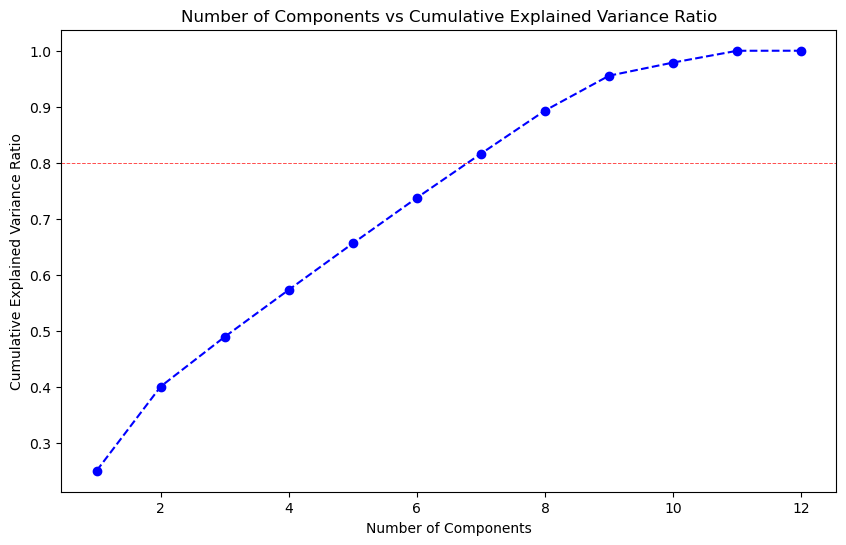

In [143]:
# Plot number of components vs cumulative explained variance ratio
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(cum_ratio) + 1), cum_ratio, marker = 'o', linestyle = '--', color = 'b')

# adding horizontal line at 80% variance which should be achieved in about 4-5 components
plt.axhline(y = 0.8, color = 'r', linestyle = '--', linewidth = 0.7, alpha = 0.7) 
plt.title('Number of Components vs Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

From the output above, we can discern that the first two components explain the most variance in the data, yet by the first 6 components, we are only explaining aboout 77.82% of the variance in the data. It takes until component 7 to surpass the minimum standard of explained variance desired (80%) when it generally should only take about 4-5.

Given that we only start with 12 features rather than thousands, we conclude that it is not necessary to limit our model to fewer dimensions. We noticed that if we were to restrict dimensionality, it can only harm our model's accuracy and it would save a minimal amount of computing time due to our small amount of features. Therefore, in order to obtain a best accuracy model, it is reasonable for us to proceed with our original dataframe with label encoding and standardization applied.

# Machine Learning Models

Now we are ready to create some models! First, we decided to run our data through various supervised machine learning models that are used to classify data. These include: SVM, Logistic Regression, K Nearest Neighbors, Decision Tree, Random Forest, and Max Voting Classifier. Since we don't know what models will be most effective, we will take the approach of trying all of them and comparing the results. Along the same lines, since we don't know what parameters to use, we will employ grid search on each model to tune our models for the highest accuracy parameters.

#### SVM - Classifier, Supervised

To find the optimal parameters for the SVM model in order to get us the best accuracy, we set up a grid search, setting various C and gamma values to run thorugh.

In [155]:
# defining parameter range
param_grid = {'C': [1, 10, 100, 500],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

# setting the grid
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(train_Xle, train_yle)

# print best parameter after tuning
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.783 total time=  19.6s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.786 total time=  19.3s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.768 total time=  18.9s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.772 total time=  18.7s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.786 total time=  19.1s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.801 total time=   9.6s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.794 total time=   9.9s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.778 total time=   9.4s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.786 total time=   9.6s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.797 total time=   9.9s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.785 total time=  10.2s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;

In [166]:
best_params = grid.best_params_
best_C = best_params.get('C')
best_gamma = best_params.get('gamma')

We find that the above parameters are the most optimal for accuracy, so we input them to our SVM model.

In [169]:
# create SVM model and train
svc = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svc.fit(train_Xle, train_yle)

# score model on training and test data
svm_train_score = svc.score(train_Xle, train_yle)
svm_test_score = svc.score(test_Xle, test_yle)
svm_preds = svc.predict(test_Xle)

# print scores
print(f'The training score is {svm_train_score}.')
print(f'The testing score is {svm_test_score}.')

The training score is 0.8266766020864381.
The testing score is 0.8025413473174667.


The training score resulting is pretty high, and the testing score is super similar meaning we arent worried about overfitting.

#### Logistic Regression - Classifier, Supervised

To find the optimal parameters for the Logistic Regression model, we created a parameter grid to test various C values, and ran the grid search in order to find the best parameters for the highest accuracy.

In [173]:
# Define the parameter grid
# Define parameter grid
log_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # Note: 'saga' supports both L1 and L2 penalties
}

# Initialize the Logistic Regression model
log = LogisticRegression()

# Set up the Grid Search
log_grid_search = GridSearchCV(estimator=log, param_grid=log_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search to the training data
log_grid_search.fit(train_Xle, train_yle)

# Get the best parameters and the best score
log_best_params = log_grid_search.best_params_
log_best_score = log_grid_search.best_score_

print(f"Best parameters found: {log_best_params}")
print(f"Best cross-validation accuracy: {log_best_score}")

# Evaluate the model with the best parameters on the test data
best_log = log_grid_search.best_estimator_
log_y_pred = best_log.predict(test_Xle)
log_test_accuracy = accuracy_score(test_yle, log_y_pred)

print(f"Test set accuracy: {log_test_accuracy}")

## You can also visualize accuracy with a confusion mmatrix! - Olivia
# c_m_LR = CM(test_yle, log_y_pred) 
# sns.heatmap(c_m_LR, annot = True, fmt = "d")

/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.7656731246895181
Test set accuracy: 0.7715812827753126


The logistic regression model parameters the grid search deemed most optimal provided us with a lower accuracy than the SVM model, although the accuracy between train and test was closer.

#### K Nearest Neighbors - Classifier, Supervised

To find the optimal parameters for the KNN model, we created a parameter grid to test a few number of neighbor values, and ran the grid search in order to find the best parameter for the highest accuracy.

In [182]:
# Define the parameter grid
knn_param_grid = {
    'n_neighbors': range(10, 40, 5),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Set up the Grid Search
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search to the training data
knn_grid_search.fit(train_Xle, train_yle)

# Get the best parameters and the best score
knn_best_params = knn_grid_search.best_params_
knn_best_score = knn_grid_search.best_score_

print(f"Best parameters found: {knn_best_params}")
print(f"Best cross-validation accuracy: {knn_best_score}")

# Evaluate the model with the best parameters on the test data
best_knn = knn_grid_search.best_estimator_
knn_y_pred = best_knn.predict(test_Xle)
knn_test_accuracy = accuracy_score(test_yle, knn_y_pred)

print(f"Test set accuracy: {knn_test_accuracy}")


Best parameters found: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Best cross-validation accuracy: 0.7838052657724789
Test set accuracy: 0.7899354578459056


The KNN model parameters that according to the grid search were most optimal provided us with a higher accuracy than the Logistic Regression model.

#### Decision Tree - Clasisfication, Supervised

To find the optimal parameters for the Decision Tree model, we created a parameter grid to test a few max depths, and ran the grid search in order to find the best parameter for the highest accuracy.

In [188]:
# Define the parameter grid
tree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']

}

# Initialize the grid search
tree_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=tree_param_grid, cv=5)

# Perform the grid search
tree_grid_search.fit(train_Xle, train_yle)

# Get the best parameters
tree_best_params = tree_grid_search.best_params_
tree_best_score = tree_grid_search.best_score_
print("Best Parameters:", tree_best_params)
print("Best train accuracy:", tree_best_score)

# Train the model with the best parameters
best_tree = DecisionTreeClassifier(**tree_best_params)
best_tree.fit(train_Xle, train_yle)

# Calculate test accuracy
acc_tree = best_tree.score(test_Xle, test_yle)
print(f'Test accuracy for the best model: {acc_tree:.2f}')

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best train accuracy: 0.790461997019374
Test accuracy for the best model: 0.79


The Decision Tree model parameters that according to the grid search were most optimal provided us with a higher test accuracy than the last two (although still smaller than SVM) and the train and test scores were very similar, again meaning that its unlikely that there is overfitting.

#### Random Forest - Classification, Supervised

To find the optimal parameters for the Random Forest model, we created a parameter grid to test a few number of estimators and max depths, and ran the grid search in order to find the best parameter for the highest accuracy.

In [191]:
# Define the parameter grid
rf_param_grid = {
    # 'n_estimators': range(100, 111),  # Adjust the range as per your preference
    # 'max_depth': range(2, 21, 2)
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the random search
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_param_grid, n_iter=10, cv=5)

# Perform the random search
random_search.fit(train_Xle, train_yle)

# Get the best parameters
best_params_rf = random_search.best_params_
print("Best Parameters:", best_params_rf)
rf_best_score = random_search.best_score_
print("Best train accuracy:", rf_best_score)

# Train the model with the best parameters
best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(train_Xle, train_yle)

# Calculate test accuracy
acc_rf = best_rf.score(test_Xle, test_yle)
print(f'Test accuracy for the best model: {acc_rf:.2f}')

/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/fionnualaeastwood/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
  

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
Best train accuracy: 0.8307501241927472
Test accuracy for the best model: 0.83


The Random Forest model parameters that according to the grid search were most optimal provided us with a very high test accuracy, much higher than any of the previous models. 

#### Max Voting Classifier

To find the optimal parameters for the Max Voting Classifier model, we collected all of the models we created above and ran them all together in order to compare their accuracy.

In [196]:
#define classifiers you want to use (single models you want to use), and use the models ran before - as they hold the selected hyperparameters 
kn_clf = knn
log_clf = log
tree_clf = best_tree
rf_clf = best_rf

# define max vote classifier - uses estimators which are all the models you want to use
voting_clf = VotingClassifier( estimators=[('kn',kn_clf),('lr',log_clf),('tree',tree_clf), ('rf',rf_clf)], voting='hard')

# train max vote classifier - fit data
voting_clf.fit(train_Xle, train_yle)

# look at and print each classifier's accuracy on the test set:
for clf in (kn_clf, log_clf, tree_clf, rf_clf, voting_clf):
    clf.fit(train_Xle, train_yle) # fit and train 
    acc_vc = clf.score(test_Xle, test_yle) # calculate test accuracy
    print(clf.__class__.__name__, acc_vc) # print

KNeighborsClassifier 0.7569584509883017
LogisticRegression 0.7716821298910851
DecisionTreeClassifier 0.7913473174667205
RandomForestClassifier 0.8306776926179911
VotingClassifier 0.8128277531262605


According to the collection of accuracies we have all together here, the Random Forest Model has the highest testing accuracy.

## Discussion of these origional models

## Fully Connected Neural Networks (NN)

For our NN, we will use tensorflow Keras sequential models.

For the imitial model, we decided to make it very simple to establish a baseline of how well even a simple model can perform when making predictions on the data. 

**Layers**
- Input neurons: 12 (12 features)
- Hidden layer 1: 10 neurons
    - This small amount was selected via the 2/3 rule stating that the number of neurons in the first hidden layer may be input_nueron + output_neuron multiplied by $\frac{2}{3}$. In our case, $(12+2) \times \frac{2}{3}$ ~ 10
    - Other 'rule of thumb' methods say the number of hidden neurons should be between the size of the input layer and the ooutput layer
- Dropout layer: p = 0.2 
    - The initial dropout value is 0.2 and will be altered to something between 0.2 - 0.5 as needed to help with overfitting
- Output layer: 1 (binary 0 or 1 for above or below median price for that state)

**Hyperparameters for the Hidden Layers**
- activation = 'relu' selected as an initial activation function
- kernel_initializer = "he_normal" selected since it tends to pair effectively with reLU activation
- loss: binary crossentropy 
- optimizer = 'adam' was selected for its general success on other models and wide utilization
- metrics: accuracy
- epochs = 20; from research, it seem 11 tends to be enough but our machines had the ability and efficinecy to run 20, which will hopefully help decrease the training loss
- batch_size = 32 selected as a starting point

### Splitting Training Data to Create Validation Data

Before creating models with the training data, we will split it into training (80%) and validation (20%) so we can monitor the performance of the model to adjust hyperparameters and detect any overfitting.

In [92]:
# train_Xle and train_yle are the training data
# Splitting some data for validation
train_X_NN, val_X_NN, train_y_NN, val_y_NN = train_test_split(train_Xle, train_yle, 
                                                              test_size = 0.2, random_state = 555)

In [100]:
# setting a seed for reproducability 
tf.random.set_seed(555)

# Creating the model
model_1 = tf.keras.Sequential([
    # defining hidden layer
    layers.Dense(10, activation = 'relu', kernel_initializer = "he_normal", input_shape = (train_Xle.shape[1],)), 
    
    # dropout layer 
    layers.Dropout(0.2),
    
    # output layer 1 neuron
    layers.Dense(1)
])

model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Fitting the model
model_1_hist = model_1.fit(
    train_X_NN, train_y_NN, 
    epochs = 20, batch_size = 32, 
    validation_data = (val_X_NN, val_y_NN),
    verbose = 0
)

In [101]:
# Print training and validation accuracies and losses
print("Training Accuracy:", round(model_1_hist.history['accuracy'][-1]*100, 2), "%")
print("Training Loss:", round(model_1_hist.history['loss'][-1], 2))
if 'val_accuracy' in model_1_hist.history:
    print("Validation Accuracy:", round(model_1_hist.history['val_accuracy'][-1] * 100, 2), "%")
    print("Validation Loss:", round(model_1_hist.history['val_loss'][-1], 2))

Training Accuracy: 78.59 %
Training Loss: 0.45
Validation Accuracy: 78.52 %
Validation Loss: 0.43


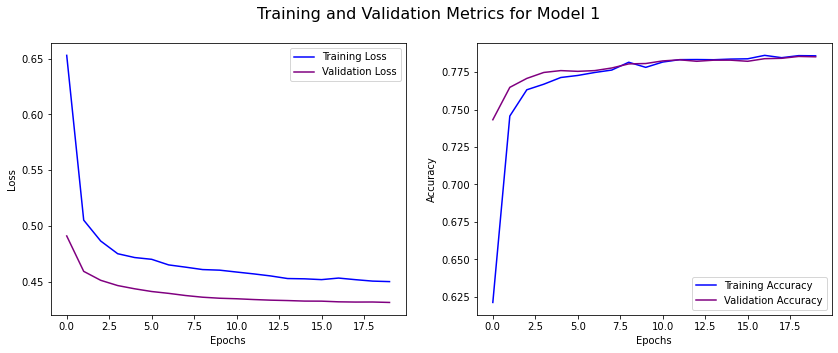

In [102]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
ax1.plot(model_1_hist.history['loss'], label='Training Loss', color='blue')
ax1.plot(model_1_hist.history['val_loss'], label='Validation Loss', color='purple')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(model_1_hist.history['accuracy'], label='Training Accuracy', color='blue')
ax2.plot(model_1_hist.history['val_accuracy'], label='Validation Accuracy', color='purple')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Set a common title for the plots
fig.suptitle('Training and Validation Metrics for Model 1', fontsize=16)

# Show the plots
plt.show()

From the plots above, we can see that the loss levels out so we will leave the number of epochs as is. The loss steadily decreases over the epochs and plateaus at 0.45 (training) and 0.43 (validation). 

The achieved training accuracy is 78.59 % and the validation Accuracy: 78.52 %. Since these are similar, it is reasonable to say that the model is not prone to overfitting, but we will compare with the testing accuracy to confirm. 

**Evaluating Model 1 on the Testing Data**

In [105]:
test_loss, test_accuracy = model_1.evaluate(test_Xle, test_yle, verbose = 0)

# Print the testing accuracy and loss
print("Testing Accuracy:", round(test_accuracy*100, 2), "%")
print("Testing Loss:", round(test_loss, 2))

Testing Accuracy: 78.67 %
Testing Loss: 0.43


As suspected, the testing accuracy of 78.67 is similar (even a little better) than the training and validation accuracies, suggesting no changes to the dropout value need to be made since overfitting is not an issue. 

## NN Hyperparameter Search

To do a more robust search to tune the hyperparameters of the NN- including how many layers to use, the number of neurons for each layer, batch size, and activation function- we will create a function that uses 'adam' optimizer 
with 'binary_crossentropy' loss function and 'accuracy' as the metric by default to compiled Keras sequential models created for binary classification. These models will test unique combinations of the hyperparameters we want to tune in order to see which is optimal. **GridSearchCV** will be applied to all the layers, activation functions, and batch sizes we want to test.

In [107]:
def create_model(layers, activation):
    """
    Creates Keras sequential models given the number of layers and 
    activation function given in the input. Uses 'adam' optimizer 
    and 'binary_crossentropy' loss function, and 'accuracy' as the 
    metric by default. 
    
    Args:
        layers: list of lists with length of the list representing
                the number of hidden layers and each element of the 
                list representing the number of neurons for each layer.
        activation: string representing the activation functionto 
                    use.
        
    Returns the compiled Keras sequential model created for binary 
    classification.
    """
    
    # defining sequential model
    model = tf.keras.Sequential()
    
    # Iterating through layers
    for i, nodes in enumerate(layers):
        # If 1 layer given
        if i == 0:
            # 1 hidden layer
            model.add(Dense(nodes, input_dim = train_Xle.shape[1], kernel_initializer = "he_normal"))
            model.add(Activation(activation))
        
        # Adding more dense layers depending on the input
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
        
        # Adding dropout layer before output to help with overfitting
        model.add(Dropout(0.2))
        
        # Output layer
        model.add(Dense(1))
        
        # Compiling the model
        model.compile(
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer = 'adam',
            metrics = ['accuracy']
        )
        
        return model

In [108]:
# setting a seed for reproducability 
tf.random.set_seed(555)

# Creating & compiling the model
model = KerasClassifier(build_fn = create_model, activation='relu', layers = 10, verbose = 0)
model

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7f98be57ee50>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	activation=relu
	layers=10
	class_weight=None
)

In [109]:
# defining layers and activation functions to test
layers = [[10], [10, 64], [10, 64, 64], [10, 64, 128, 64]]
activations = ['sigmoid', 'relu']

# defining a parameter search grid
param_grid = dict(
    layers = layers, 
    activation = activations, 
    batch_size = [16, 32], 
    epochs = [20]
)
grid = GridSearchCV(
    estimator = model, 
    param_grid = param_grid
)

In [110]:
# Fitting models with the unique combinations of hyperparameters given the testing criteria
grid_results = grid.fit(train_Xle, train_yle)

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the f

**Best Model According to GridSearchCV**

In [111]:
# Getting best model
[grid_results.best_score_, grid_results.best_params_]

[0.7912892958971741,
 {'activation': 'relu', 'batch_size': 16, 'epochs': 20, 'layers': [10]}]

After running model iterations with deeper and wider NN, the most simplistic NN with 1 hidden layer containing 10 neurons was selected as the optimal model. It achieved a training accuracy of about 79% with hyperparameters:

- 'activation': 'relu'
- 'batch_size': 16
- 'epochs': 20

### Creating the 'Best' Model

In [124]:
# setting a seed for reproducability 
tf.random.set_seed(555)

# Creating the model
model_best = tf.keras.Sequential([
    # defining hidden layer
    layers.Dense(10, activation = 'relu', kernel_initializer = "he_normal", input_shape = (train_Xle.shape[1],)), 
    
    # dropout layer 
    layers.Dropout(0.2),
    
    # output layer 1 neuron
    layers.Dense(1)
])

model_best.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Fitting the model
model_best_hist = model_best.fit(
    train_X_NN, train_y_NN, 
    epochs = 20, batch_size = 16, 
    validation_data = (val_X_NN, val_y_NN),
    verbose = 0
)

In [125]:
# Print training and validation accuracies and losses
print("Training Accuracy:", round(model_best_hist.history['accuracy'][-1]*100, 2), "%")
print("Training Loss:", round(model_best_hist.history['loss'][-1], 2))
if 'val_accuracy' in model_best_hist.history:
    print("Validation Accuracy:", round(model_best_hist.history['val_accuracy'][-1] * 100, 2), "%")
    print("Validation Loss:", round(model_best_hist.history['val_loss'][-1], 2))

Training Accuracy: 78.58 %
Training Loss: 0.45
Validation Accuracy: 78.55 %
Validation Loss: 0.43


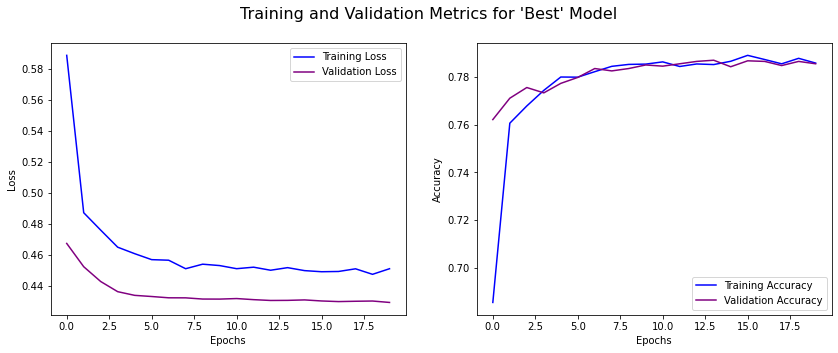

In [126]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
ax1.plot(model_best_hist.history['loss'], label='Training Loss', color='blue')
ax1.plot(model_best_hist.history['val_loss'], label='Validation Loss', color='purple')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(model_best_hist.history['accuracy'], label='Training Accuracy', color='blue')
ax2.plot(model_best_hist.history['val_accuracy'], label='Validation Accuracy', color='purple')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Set a common title for the plots
fig.suptitle('Training and Validation Metrics for \'Best\' Model', fontsize=16)

# Show the plots
plt.show()

From the plots above, we can see that again, the loss levels out so we will leave the number of epochs as is. The loss steadily decreases over the epochs and plateaus at 0.45 (training) and 0.43 (validation). 

The achieved training accuracy is 78.58 % and the validation Accuracy: 78.55 %. Since these are similar, it is reasonable to say that the model is not prone to overfitting, but we will compare with the testing accuracy to confirm. 

**Evaluating Best Model on the Testing Data**

<AxesSubplot:>

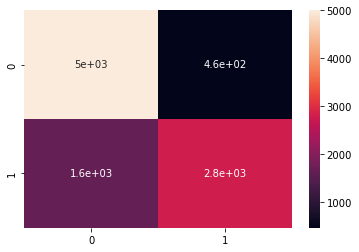

In [135]:
## Visualizing
# predicting the test set results
y_preds_best = model_best.predict(test_Xle, verbose = 0)
y_preds_best = (y_preds_best > 0.5)

# Making the confusion matrix 
conf_mat_best = confusion_matrix(test_yle, y_preds_best)
sns.heatmap(conf_mat_best, annot = True)

Given the testing accuracy, we know (and can visualize) that the model is making errors. By constructing a confusion matrix of the y predictions compared to the test y labels, we can see that the model is makeing more False Negative (FN) errors as opposed to False Positive (FP) errors. This means that the model tends to inaccurately classify houses that are above the median price per the state as below the median price of the state. Implications of this error are that a buyer may get the house at a cheaper rate while a seller may innacuraltely devalue the house based on this prediction. 

In [136]:
best_test_loss, best_test_accuracy = model_best.evaluate(test_Xle, test_yle, verbose = 0)

# Print the testing accuracy and loss
print("Testing Accuracy:", round(best_test_accuracy*100, 2), "%")
print("Testing Loss:", round(best_test_loss, 2))

Testing Accuracy: 78.66 %
Testing Loss: 0.43


As suspected, the testing accuracy of 78.66 % is similar (even a little better) than the training and validation accuracies, suggesting no changes to the dropout value need to be made since overfitting is not an issue and the model performs fairly well. 

Next, we will conduct cross validation to see if the model generally performs this well.

### Cross Validation on 'Best' NN

Using K-fold as the cross validation model validation technique. Since the dataset is fairly large, we selected 20 folds so that it will run more efficiently.

In [127]:
def create_best_model():
    """
    Creates best Keras sequential model given the hyperparameter
    search above.
    
    Returns the compiled Keras sequential model created for binary 
    classification.
    """
    
    # defining sequential model
    best_model = tf.keras.Sequential()
    
    # Hidden layer #1
    best_model.add(Dense(10, input_dim = train_Xle.shape[1], kernel_initializer = "he_normal"))
    best_model.add(Activation('relu'))
    
    # Dropout layer
    best_model.add(Dropout(0.2))
    
    # Output layer
    best_model.add(Dense(1))
    
    # Compiling the model
    best_model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    return best_model

In [128]:
# Creating the model
best_nn_model = KerasClassifier(
    build_fn = create_best_model, 
    epochs = 20, 
    batch_size = 16, 
    verbose = 0
)

best_nn_model

KerasClassifier(
	model=None
	build_fn=<function create_best_model at 0x7f98e7353430>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight=None
)

In [133]:
# evaluating using 20-fold cross validation
kfold = KFold(n_splits = 20, shuffle = True, random_state = 42)
results = cross_val_score(best_nn_model, test_Xle, test_yle, cv=kfold)

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/Users/oliviaweisiger/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the f

In [144]:
print("The minimum accuracy across 20 folds of the testing data is", round(results.min()*100, 2), "%")
print("The maximum accuracy across 20 folds of the testing data is", round(results.max()*100, 2), "%")
print("The average accuracy across 20 folds of the testing data is", round(results.mean()*100, 2), "%")
print("The the standard deviation of accuracy across 20 folds of the testing data is", 
      round(results.std(), 2))

The minimum accuracy across 20 folds of the testing data is 76.77 %
The maximum accuracy across 20 folds of the testing data is 82.83 %
The average accuracy across 20 folds of the testing data is 78.84 %
The the standard deviation of accuracy across 20 folds of the testing data is 0.01


Text(0.5, 1.0, 'Training Accuracy Across 20-Folds')

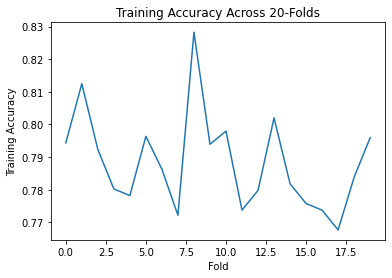

In [140]:
# visualization of the accuracy curve over the 20-folds
plt.plot(results)
plt.xlabel("Fold")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Across 20-Folds")

Results of the 20-fold CV are positive as the convey the model can perform similarly well across random splits of the data, suggesting it supplies results with consistent accuracies and accuracies in the high 70s/low 80s are not just random luck.

# Conclusion
## Discussion of Findings

## Limitations